In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib as mp
import matplotlib.pyplot as plt
import pickle
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from evaluate import *

In [225]:
basin_metrics[0]['usgs_q']['MAPE'].dropna()

71226600041    164.355944
72554000171    200.427944
72556000451     25.648699
72558200361     57.729557
72582400271     83.328136
                  ...    
78280100061     73.578643
78291000071      93.68435
78299900081     39.471223
78310600051     43.267002
78310800021     44.529972
Name: MAPE, Length: 100, dtype: object

In [226]:
np.quantile(basin_metrics[0]['usgs_q']['MAPE'].dropna(),[0.25, 0.5, 0.75])

array([np.float64(34.1118281312825), np.float64(51.62831683327123),
       np.float64(84.9496303999459)], dtype=object)

In [212]:
fig_dir = Path("../runs/swotq_basinSplit/_figures")
exp_dict = {
    'ERA5 & SWOT': Path("../runs/swotq_basinSplit/base_config_20241006_234618"),
    'ERA5 only': Path("../runs/swotq_basinSplit/era5_only_20241006_234548")
}
# Define colors and styles
both_color = '#d95f02'
e5_color = '#1b9e77'
s_color = '#7570b3'
line_styles = [(both_color,'-'),(e5_color,'-')]
# Create custom legend elements
legend_elements = [
    mp.lines.Line2D([0], [0], color=both_color, lw=2, label='ERA5 & SWOT'),
    mp.lines.Line2D([0], [0], color=e5_color, lw=2, label='ERA5')
]
fig_dir.mkdir(exist_ok=True, parents=True)
            

exp_names = []
results = []
bulk_metrics = []
basin_metrics = []
predict_results = []
for exp_name, exp_dir in exp_dict.items():
    exp_names.append(exp_name)
    with open(exp_dir / "test_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        
        lt10 = basin_m['usgs_q']['num_obs'] < 10
        basin_m.loc[lt10, 'usgs_q'] = np.nan
        
        results.append(r)
        bulk_metrics.append(bulk_m)
        basin_metrics.append(basin_m)
        
    with open(exp_dir / "predict_data.pkl", 'rb') as f:
        r, bulk_m, basin_m = pickle.load(f)
        predict_results.append(r)
        


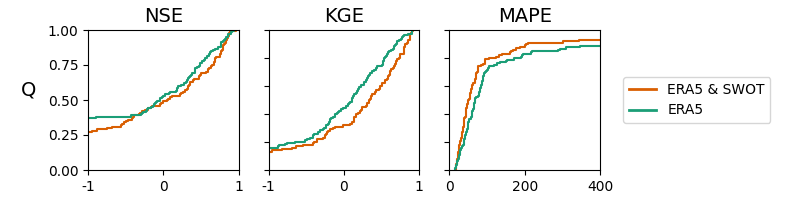

In [217]:
plt.close('all')

metric_args = {
    'NSE':{'range':[-1,1]},
    'KGE':{'range':[-1,1]},
    'MAPE': {'range':[0,400]}
    }

nCols = len(metric_args)
fig, axes = plt.subplots(1, nCols, figsize=(8, 2))

for (metric, metric_kwargs), ax in zip(metric_args.items(), axes):
    for m, (c, s) in zip(basin_metrics, line_styles):
        x = m['usgs_q', metric].astype(float)
        x = x[np.isfinite(x)]

        # if 'bias' in metric.lower():
        #     x = np.abs(x)

        ax.ecdf(x, color=c, linestyle=s)

    # ax.set_aspect(1./ax.get_data_ratio())
    ax.set_xlim(metric_kwargs['range'])
    ax.set_ylim([0,1])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
        
# Top Axes
for (metric, _), ax in zip(metric_args.items(), axes):
    ax.set_title(metric, fontsize=14)
    
# Bottom Axes
for ax in axes:
    ax.set_xticks(np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3))
    ax.set_xticklabels([int(label) for label in np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 3)])
    
# Left Axes
axes[0].set_ylabel('Q', rotation=0, ha='right', fontsize=14, labelpad=8)
axes[0].set_yticks(np.linspace(0, 1, 5))
axes[0].set_yticklabels([f"{lab:0.2f}" for lab in np.linspace(0, 1, 5)])
    

# Adjust spacing to make room for the legend
plt.subplots_adjust(top=0.85, bottom=0.15, left=0.11, right=0.75)

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.77, 0.5))


# fig.tight_layout()
plt.show()

fig.savefig(fig_dir / "ablation_cdfs.png",  dpi=300)

In [67]:
basin_metrics[0]['usgs_q']['KGE'].median()

np.float64(0.3426837611483313)

In [113]:
results[0]

Type                            obs         pred   dt     
Feature                      usgs_q       usgs_q era5 swot
basin       date                                          
73150600321 2024-07-26   161.972351    33.105885    0   91
73130000151 2024-06-08    13.677035     9.332781    0   50
73160401141 2024-03-22    25.400209    17.171986    0   91
74269700031 2024-07-14   171.883194    52.235832    0   12
78310600051 2024-02-28   291.663422   227.954529    0   91
...                             ...          ...  ...  ...
72586000281 2023-10-05    25.626743    22.646780    0   91
74287300281 2024-04-23  1849.090210  1203.380371    0   30
73160100011 2024-04-06  7447.332520  4580.280762    0    8
72586000281 2024-01-30   129.691101   143.655807    0   84
73120000211 2023-10-19   196.518890   227.260361    0   17

[54176 rows x 4 columns]

In [156]:
num_obs = basin_metrics[0]['usgs_q']['num_obs'] > 0
nse = basin_metrics[0]['usgs_q']['NSE']> 0
mask = num_obs & nse
mask_ids = mask.index[mask == True].tolist()
print(mask.sum())

# basin = basin_metrics[0].loc[mask,('usgs_q','KGE')].idxmin()
basin = basin_metrics[0].loc[mask_ids].sample(1).index[0]

print(basin_metrics[0].loc[basin])


51
Feature  Metric   
usgs_q   num_obs             95
         R2             0.66933
         MAPE         27.193825
         nBias         0.558642
         RE           25.036871
         RB            5.426705
         MAE          54.629139
         RMSE         92.261101
         rRMSE        45.049511
         KGE           0.658712
         NSE           0.336215
         Agreement      0.77929
Name: 73114000751, dtype: object


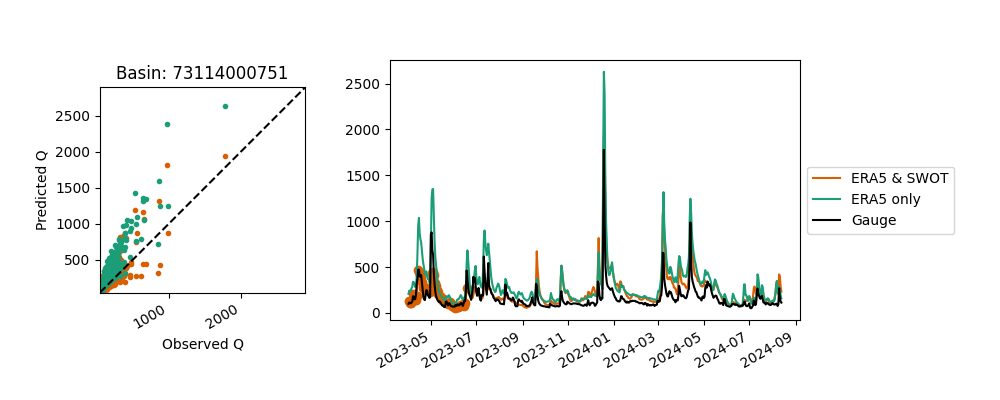

In [164]:
import matplotlib.gridspec as gridspec

"""
"""

# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

legend_elements = []
mins, maxs = [], []
for preds, name, (c, s) in zip(predict_results, exp_names, line_styles):
    basin_mask  = preds.index.get_level_values('basin') == basin
    sorted_df = preds[basin_mask].sort_values('date')
    
    date = sorted_df.index.get_level_values('date')
    values = sorted_df['pred']['usgs_q'].values
    obs = sorted_df['obs']['usgs_q'].values
    
    if ('dt','swot') in sorted_df.columns:
        swot_mask = sorted_df['dt','swot'] == 0
        axes[1].scatter(date[swot_mask], values[swot_mask], color=c, label=name)
 
    l = axes[1].plot(date, values, color=c, label=name)
    legend_elements.extend(l)
        
    mins.extend([np.nanmin(values), np.nanmin(obs)])
    maxs.extend([np.nanmax(values), np.nanmax(obs)])
    
    axes[0].scatter(obs, values, marker='.',color=c)
    
l = axes[1].plot(date, obs, color='k', zorder=10, label='Gauge')
legend_elements.extend(l)

min_val = float(np.min(mins))*0.9
max_val = float(np.max(maxs))*1.1
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].axis('square')
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed Q")
axes[0].set_ylabel(f"Predicted Q")
axes[0].set_title(f"Basin: {basin}")


fig.subplots_adjust(top=0.85, left=0.1, right=0.8, wspace=0.1, hspace=0.4)
fig.autofmt_xdate()

fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.8, 0.5))

plt.show()

fig.savefig(fig_dir / f"{basin}_timeseries.png",  dpi=300)

In [150]:
basin

'72586000051'

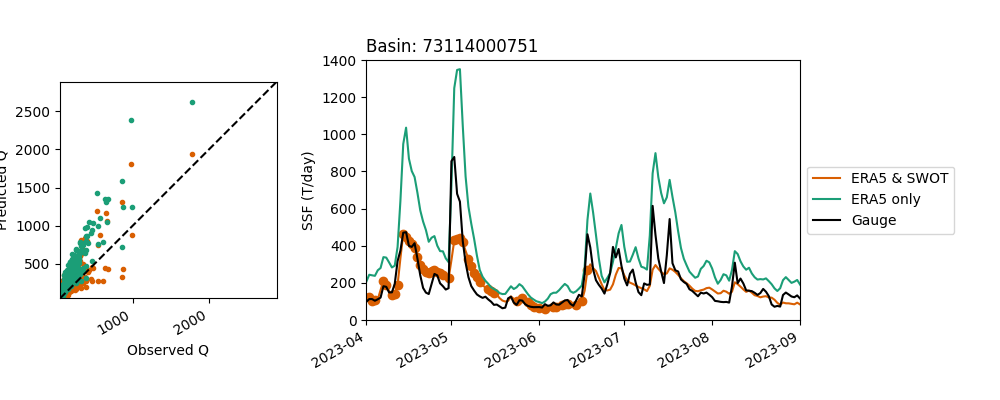

In [163]:
import matplotlib.gridspec as gridspec

"""
basin = '78220000221'
start_date = np.datetime64('2023-04-01')
end_date = np.datetime64('2023-07-01')
y_max = 1400

basin = '72586000051'
start_date = np.datetime64('2024-01-01')
end_date = np.datetime64('2024-09-01')
y_max = 1750


"""
basin = '73114000751'
start_date = np.datetime64('2023-04-01')
end_date = np.datetime64('2023-09-01')
y_max = 1400



# Plot the true values and predictions
plt.close('all')

# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

legend_elements = []
mins, maxs = [], []
for preds, name, (c, s) in zip(predict_results, exp_names, line_styles):
    basin_mask  = preds.index.get_level_values('basin') == basin
    sorted_df = preds[basin_mask].sort_values('date')
    
    date = sorted_df.index.get_level_values('date')
    values = sorted_df['pred']['usgs_q'].values
    obs = sorted_df['obs']['usgs_q'].values
    
    if ('dt','swot') in sorted_df.columns:
        swot_mask = sorted_df['dt','swot'] == 0
        axes[1].scatter(date[swot_mask], values[swot_mask], color=c, label=name)
 
    l = axes[1].plot(date, values, color=c, label=name)
    legend_elements.extend(l)
        
    mins.extend([np.nanmin(values), np.nanmin(obs)])
    maxs.extend([np.nanmax(values), np.nanmax(obs)])
    
    axes[0].scatter(obs, values, marker='.',color=c)
    
l = axes[1].plot(date, obs, color='k', zorder=10, label='Gauge')
legend_elements.extend(l)

min_val = float(np.min(mins))*0.9
max_val = float(np.max(maxs))*1.1
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--')

# Setting axes to be square and equal range
axes[0].axis('square')
# axes[0].set_xscale('log')
# axes[0].set_yscale('log')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed Q")
axes[0].set_ylabel(f"Predicted Q")
axes[1].set_title(f"Basin: {basin}", loc='left')

axes[1].set_xlim(start_date, end_date)
axes[1].set_ylim(0, y_max)
axes[1].set_ylabel("SSF (T/day)")

fig.subplots_adjust(top=0.85, left=0.06, right=0.8, wspace=0.1, hspace=0.4)
fig.autofmt_xdate()


fig.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(0.8, 0.5))


plt.show()

fig.savefig(fig_dir / f"{basin}_zoom_timeseries.png",  dpi=300)

In [174]:
for i, model_data in enumerate(results):
    y = model_data['obs']['usgs_q']
    y_hat = model_data['pred']['usgs_q']
    mask = (y+y_hat).isna()
    break

In [193]:
type(metric_list[0])

numpy.ndarray

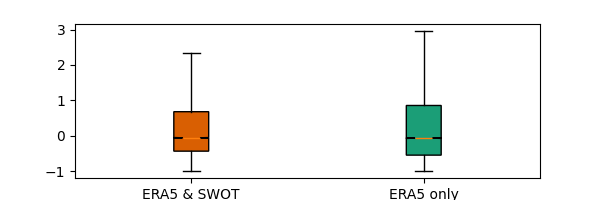

In [200]:
metric_names = {
    'qRE': 'Relative Error (%)',
    'qnBias':'Normalized Bias (%)'
}

num_models = len(results)
target_variables = ['usgs_q']
num_targets = len(target_variables)

fig, ax = plt.subplots(figsize=(6, 2))

colors = [t[0] for t in line_styles]
lines = [t[1] for t in line_styles]

metric_list = []
for model_data in results:
    y = model_data['obs']['usgs_q']
    y_hat = model_data['pred']['usgs_q']
    
    nBias = (y_hat - y) / y
    metric_list.append(nBias.values)
    
bplot = ax.boxplot(metric_list, notch=True, showfliers=False, patch_artist=True, tick_labels=exp_dict.keys())

# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


# fig.savefig(fig_dir / f"bulk_barplots_errorbars.png",  dpi=300)

In [168]:
results[0]['obs']

Type                            obs         pred   dt     
Feature                      usgs_q       usgs_q era5 swot
basin       date                                          
73150600321 2024-07-26   161.972351    33.105885    0   91
73130000151 2024-06-08    13.677035     9.332781    0   50
73160401141 2024-03-22    25.400209    17.171986    0   91
74269700031 2024-07-14   171.883194    52.235832    0   12
78310600051 2024-02-28   291.663422   227.954529    0   91
...                             ...          ...  ...  ...
72586000281 2023-10-05    25.626743    22.646780    0   91
74287300281 2024-04-23  1849.090210  1203.380371    0   30
73160100011 2024-04-06  7447.332520  4580.280762    0    8
72586000281 2024-01-30   129.691101   143.655807    0   84
73120000211 2023-10-19   196.518890   227.260361    0   17

[54176 rows x 4 columns]